# Определение перспективного тарифа для телеком компании

### Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


### Описание тарифов

**Тариф «Смарт»**
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* Минута разговора: 3 рубля
* Сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей  

**Тариф «Ультра»**
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* Минута разговора: 1 рубль
* Сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей  

Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### Описание данных  

**Таблица users** (информация о пользователях):  
_user_id_ — уникальный идентификатор пользователя  
_first_name_ — имя пользователя  
_last_name_ — фамилия пользователя  
_age_ — возраст пользователя (годы)  
_reg_date_ — дата подключения тарифа (день, месяц, год)  
_churn_date_ — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
_city_ — город проживания пользователя  
_tariff_ — название тарифного плана  

**Таблица calls** (информация о звонках):  
_id_ — уникальный номер звонка  
_call_date_ — дата звонка  
_duration_ — длительность звонка в минутах  
_user_id_ — идентификатор пользователя, сделавшего звонок 

**Таблица messages** (информация о сообщениях): 
_id_ — уникальный номер сообщения  
_message_date_ — дата сообщения  
_user_id_ — идентификатор пользователя, отправившего сообщение  

**Таблица internet** (информация об интернет-сессиях):  
_id_ — уникальный номер сессии  
_mb_used_ — объём потраченного за сессию интернет-трафика (в мегабайтах)  
_session_date_ — дата интернет-сессии  
_user_id_ — идентификатор пользователя  

**Таблица tariffs** (информация о тарифах):  
_tariff_name_ — название тарифа  
_rub_monthly_fee_ — ежемесячная абонентская плата в рублях  
_minutes_included_ — количество минут разговора в месяц, включённых в абонентскую плату  
_messages_included_ — количество сообщений в месяц, включённых в абонентскую плату  
_mb_per_month_included_ — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
_rub_per_minute_ — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
_rub_per_message_ — стоимость отправки сообщения сверх тарифного пакета  
_rub_per_gb_ — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Шаг 1. Открытие файла, изучение общей информации

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

Сразу изменяем типы данных при считывании дат и исправляем первую колонку в internet.

In [2]:
calls = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])

In [3]:
internet = pd.read_csv('/datasets/internet.csv', index_col=0, parse_dates=['session_date'])

In [4]:
messages = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])

In [5]:
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [6]:
users = pd.read_csv('/datasets/users.csv', parse_dates=['churn_date','reg_date'])

**Начнем с просмотра информации о users.**

In [7]:
users.head(20)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaT,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaT,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaT,Пермь,Василиса,Блинова,2018-03-22,smart


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [9]:
users.age.min()

18

In [10]:
users.tariff.unique()

array(['ultra', 'smart'], dtype=object)

In [11]:
users.duplicated().sum()

0

* _churn_date_ - дата прекращения пользования тарифом. Для удобства я бы заменила _nan_ на 2018-12-31, так как мы все-таки анализируем 2018 год.  
* Хорошо бы объединить столбец _first_name_ и _last_name_.
* Нет никаких опечаток-ошибок в названиях тарифа в столбце _tariff_
* Дубликатов нет


**Просмотрим информацию о calls.**

In [12]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [13]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [14]:
calls.query('duration == "0"').count()

id           39613
call_date    39613
duration     39613
user_id      39613
dtype: int64

In [15]:
39613/202607*100

19.551644316336553

* Надо округлять значения колонки duration до минут. 
* Считаю, что нет смысла оставлять данные в таблице, где duration звонка равна 0. Ибо для результата и для анализа нам эти данные не нужны.


**Посмотрим информацию о messages.**

In [16]:
messages.head(5)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [17]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


**internet:**

In [18]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [19]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


* Перевести тип session_date в date_time

**tariffs:**

In [20]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [21]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


* C данной таблицей все нормально

#### Вывод: 
**Для таблицы users следующие выводы:**
* churn_date - дата прекращения пользования тарифом. Для удобства я бы заменила nan на 2018-12-31, так как мы все-таки анализируем 2018 год
* Хорошо бы объединить столбец _first_name_ и _last_name_ 

**Для таблицы calls:**
* В _calls_ nun нет
* Надо округлять значения колонки duration до минут 

**В целом:**
* В остальных таблицах явных проблем нет
* Дубликатов нет
* Огромное количество Nan в churn_date - результат того, что тарифом пользуются после 

### Шаг 2. Подготовка данных.

**Начнем обработку с таблицы _users_.**

In [22]:
users['churn_date'].fillna('2018-12-31', inplace = True)

Добавим в _users_ стобец _name_ , состоящий из _last_name_ и _first_name_. Затем удалим столбцы _last_name_ и _first_name_.


In [23]:
users["name"] = users["last_name"] + ' ' +users["first_name"]

In [24]:
users.drop(columns = ['last_name','first_name'], inplace = True)

In [25]:
users

,user_id,age,churn_date,city,reg_date,tariff,name
0,1000,52,2018-12-31,Краснодар,2018-05-25,ultra,Верещагин Рафаил
1,1001,41,2018-12-31,Москва,2018-11-01,smart,Ежов Иван
2,1002,59,2018-12-31,Стерлитамак,2018-06-17,smart,Абрамович Евгений
3,1003,23,2018-12-31,Москва,2018-08-17,ultra,Белякова Белла
4,1004,68,2018-12-31,Новокузнецк,2018-05-14,ultra,Авдеенко Татьяна
...,...,...,...,...,...,...,...
495,1495,65,2018-12-31,Иркутск,2018-08-28,ultra,Фокин Авксентий
496,1496,36,2018-12-31,Вологда,2018-01-27,smart,Блохин Трифон
497,1497,32,2018-12-31,Челябинск,2018-10-09,smart,Агеева Каролина
498,1498,68,2018-10-25 00:00:00,Владикавказ,2018-07-19,smart,Акимчин Всеволод


In [26]:
users.city.unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [27]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    500 non-null object
city          500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
name          500 non-null object
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 27.5+ KB


In [28]:
users.duplicated().sum()

0

**Обработка таблицы calls.**

In [29]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Округлим значения колонки duration до минут.

In [30]:
calls['duration'] = calls['duration'].apply(lambda x: math.ceil(x))

Удалю строчки, где duration звонка равна 0 в данной таблице.

In [31]:
calls = calls.query('duration != 0')

In [32]:
calls.tail(5)

,id,call_date,duration,user_id
202602,1499_215,2018-12-26,1,1499
202603,1499_216,2018-10-18,19,1499
202604,1499_217,2018-11-10,11,1499
202605,1499_218,2018-10-06,5,1499
202606,1499_219,2018-12-14,20,1499


**Обработка таблицы internet**.

In [33]:
internet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [34]:
internet.query('mb_used == 0')

,id,mb_used,session_date,user_id
11,1000_11,0.0,2018-08-28,1000
38,1000_38,0.0,2018-11-27,1000
46,1000_46,0.0,2018-06-30,1000
67,1000_67,0.0,2018-06-16,1000
72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...
149380,1499_141,0.0,2018-12-11,1499
149381,1499_142,0.0,2018-11-01,1499
149383,1499_144,0.0,2018-11-27,1499
149386,1499_147,0.0,2018-10-21,1499


In [35]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


In [36]:
internet.query('mb_used == 0').count()

id              19598
mb_used         19598
session_date    19598
user_id         19598
dtype: int64

In [37]:
19598/149396

0.13118155773916304

Посчитаем для каждого пользователя **количество сделанных звонков** и **израсходованных минут разговора по месяцам**.  
Пусть _count_calls_ - **количество сделанных звонков**  - добавим в новую таблицу count_calls  
_minutes_month_ - **израсходованные минуты разговора по месяцам** - добавлю в новую таблицу minutes_month

In [38]:
calls.head(5)

,id,call_date,duration,user_id
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
7,1000_7,2018-08-22,19,1000
8,1000_8,2018-09-15,19,1000


In [39]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month


In [40]:
calls

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9
...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,12
202603,1499_216,2018-10-18,19,1499,10
202604,1499_217,2018-11-10,11,1499,11
202605,1499_218,2018-10-06,5,1499,10


In [41]:
count_calls = calls.groupby(['user_id', 'month'], as_index = False).count().drop(columns=['call_date','duration']).rename(columns={'id':'count_calls'})

In [42]:
count_calls

,user_id,month,count_calls
0,1000,5,17
1,1000,6,28
2,1000,7,41
3,1000,8,42
4,1000,9,46
...,...,...,...
3163,1498,10,30
3164,1499,9,8
3165,1499,10,44
3166,1499,11,62


In [43]:
minutes_month = calls.groupby(['user_id','month'], 
                               as_index = False).sum().rename(columns={'duration':'minutes_passed'})

In [44]:
minutes_month

,user_id,month,minutes_passed
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466
...,...,...,...
3163,1498,10,247
3164,1499,9,70
3165,1499,10,449
3166,1499,11,612


Посчитаем для каждого пользователя **количество отправленных сообщений по месяцам** - назовем переменную новую _count_messages_ и добавим таблицу count_messages.

In [45]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month



In [46]:
messages.head(5)

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [47]:
count_messages = messages.groupby(['user_id','month'],
                               as_index = False).count().rename(columns=
                                                                {'id':'count_messages'}).drop(columns='message_date')

In [48]:
count_messages.head(5)

,user_id,month,count_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [49]:
users.head(5)

,user_id,age,churn_date,city,reg_date,tariff,name
0,1000,52,2018-12-31,Краснодар,2018-05-25,ultra,Верещагин Рафаил
1,1001,41,2018-12-31,Москва,2018-11-01,smart,Ежов Иван
2,1002,59,2018-12-31,Стерлитамак,2018-06-17,smart,Абрамович Евгений
3,1003,23,2018-12-31,Москва,2018-08-17,ultra,Белякова Белла
4,1004,68,2018-12-31,Новокузнецк,2018-05-14,ultra,Авдеенко Татьяна


Посчитаем объем израсходованного интернет-трафика по месяцам.  
Назовем объем _mb_used_month_ и создадим новую таблицу mb_used_month


In [50]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [51]:
internet.head(5)

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [52]:
mb_used_month = internet.groupby(['user_id','month'],
                               as_index = False).sum().rename(columns=
                                                                {'mb_used':'mb_used_month'})

In [53]:
mb_used_month.head(5)

,user_id,month,mb_used_month
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


Посчитаем помесячную выручку с каждого пользователя. Обозначим новую переменную _revenue_month_.  
Для этого объединим 3 таблицы - count_messages, minutes_month, mb_used_month и users в таблицу for_revenue.

In [54]:
for_revenue = users.merge(count_messages.merge(
    minutes_month.merge(mb_used_month, on=['user_id', 'month'], how='outer'),
    on=['user_id', 'month'], how='outer'), on='user_id', how='outer').drop(columns=['age','city','churn_date','reg_date','name'])

In [55]:
for_revenue

,user_id,tariff,month,count_messages,minutes_passed,mb_used_month
0,1000,ultra,5.0,22.0,159.0,2253.49
1,1000,ultra,6.0,60.0,172.0,23233.77
2,1000,ultra,7.0,75.0,340.0,14003.64
3,1000,ultra,8.0,81.0,408.0,14055.93
4,1000,ultra,9.0,57.0,466.0,14568.91
...,...,...,...,...,...,...
3211,1498,smart,10.0,42.0,247.0,20579.36
3212,1499,smart,9.0,11.0,70.0,1845.75
3213,1499,smart,10.0,48.0,449.0,17788.51
3214,1499,smart,11.0,59.0,612.0,17963.31


In [56]:
for_revenue.isnull().query('count_messages == True and minutes_passed == True')

,user_id,tariff,month,count_messages,minutes_passed,mb_used_month
827,False,False,True,True,True,True
1529,False,False,False,True,True,False
2335,False,False,True,True,True,True
3074,False,False,False,True,True,False


In [57]:
for_revenue.isnull().sum()

user_id             0
tariff              0
month               2
count_messages    499
minutes_passed     48
mb_used_month      13
dtype: int64

In [58]:
for_revenue = for_revenue.fillna(0)

In [59]:
for_revenue.query('count_messages == 0')

,user_id,tariff,month,count_messages,minutes_passed,mb_used_month
8,1001,smart,11.0,0.0,430.0,18429.34
9,1001,smart,12.0,0.0,414.0,14036.66
42,1006,smart,2.0,0.0,42.0,1392.15
43,1006,smart,3.0,0.0,286.0,17287.93
44,1006,smart,4.0,0.0,356.0,13936.70
...,...,...,...,...,...,...
3183,1494,smart,8.0,0.0,262.0,6590.75
3184,1494,smart,9.0,0.0,501.0,16962.51
3185,1494,smart,10.0,0.0,354.0,17767.24
3186,1494,smart,11.0,0.0,411.0,18052.45


In [60]:
for_revenue.query('minutes_passed == 0')

,user_id,tariff,month,count_messages,minutes_passed,mb_used_month
570,1091,ultra,5.0,30.0,0.0,10703.37
571,1091,ultra,6.0,30.0,0.0,10236.19
572,1091,ultra,7.0,35.0,0.0,16444.98
573,1091,ultra,8.0,31.0,0.0,12633.88
574,1091,ultra,9.0,32.0,0.0,16597.11
575,1091,ultra,10.0,44.0,0.0,15644.73
576,1091,ultra,11.0,28.0,0.0,11864.25
577,1091,ultra,12.0,42.0,0.0,13280.45
671,1106,ultra,4.0,9.0,0.0,2923.49
672,1106,ultra,5.0,28.0,0.0,16573.01


In [61]:
for_revenue=for_revenue.query('month != 0')

In [62]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [63]:
for tariff_name in tariffs.tariff_name.unique(): 
    print(tariff_name)

smart
ultra


In [64]:
tariffs[tariffs.tariff_name == 'ultra']['rub_monthly_fee'].values[0]

1950

In [65]:
def revenue(row):  
    for tariff_name in tariffs.tariff_name.unique(): 
        if tariff_name == row['tariff']:
            total_messages = 0
            total_megabytes = 0
            total_minutes = 0
            if row['count_messages'] > tariffs[tariffs.tariff_name == tariff_name]['messages_included'].values[0]:
                total_messages = (row['count_messages'] - tariffs[tariffs.tariff_name == tariff_name]['messages_included'].values[0]) * tariffs[tariffs.tariff_name == tariff_name]['rub_per_message'].values[0]     
            if row['mb_used_month'] > tariffs[tariffs.tariff_name == tariff_name]['mb_per_month_included'].values[0]:
                total_megabytes = (np.ceil(row['mb_used_month']) - tariffs[tariffs.tariff_name == tariff_name]['mb_per_month_included'].values[0]) * tariffs[tariffs.tariff_name == tariff_name]['rub_per_gb'].values[0]/1024
            if row['minutes_passed'] > tariffs[tariffs.tariff_name == tariff_name]['minutes_included'].values[0]:
                total_minutes = (row['minutes_passed'] - tariffs[tariffs.tariff_name == tariff_name]['minutes_included'].values[0]) * tariffs[tariffs.tariff_name == tariff_name]['rub_per_minute'].values[0]
            return total_megabytes + total_minutes + total_messages + tariffs[tariffs.tariff_name == tariff_name]['rub_monthly_fee'].values[0]


In [66]:
for_revenue['profit'] = for_revenue.apply(revenue,axis=1)

In [67]:
for_revenue.head(20)

,user_id,tariff,month,count_messages,minutes_passed,mb_used_month,profit
0,1000,ultra,5.0,22.0,159.0,2253.49,1950.000000
1,1000,ultra,6.0,60.0,172.0,23233.77,1950.000000
2,1000,ultra,7.0,75.0,340.0,14003.64,1950.000000
3,1000,ultra,8.0,81.0,408.0,14055.93,1950.000000
4,1000,ultra,9.0,57.0,466.0,14568.91,1950.000000
5,1000,ultra,10.0,73.0,350.0,14702.49,1950.000000
6,1000,ultra,11.0,58.0,338.0,14756.47,1950.000000
7,1000,ultra,12.0,70.0,333.0,9817.61,1950.000000
8,1001,smart,11.0,0.0,430.0,18429.34,1149.609375
9,1001,smart,12.0,0.0,414.0,14036.66,550.000000


#### Вывод:


* В users заменила nan на 2018-12-31, так как мы все-таки анализируем 2018 год
* Добавили в _users_ стобец _name_ , состоящий из _last_name_ и _first_name_. Затем удалили столбцы _last_name_ и _first_name_
* Округлили значения колонки duration до минут
* Избавились от Unnamed колонки в internet
* Привели к правильным типам данные во всех таблицах
* Заменили пустые значения на 0 в пустых столбцах
* Посчитали для каждого пользователя:  
  *  количество сделанных звонков и израсходованных минут разговора по месяцам;  
  *  количество отправленных сообщений по месяцам; 
  * объем израсходованного интернет-трафика по месяцам;
  * помесячную выручку с каждого пользователя

### Шаг 3. Анализ данных.

Проанализируем для начала тариф ultra.

Найдем **дисперсию, среднюю, медиану, дисперсию и среднее отклонение минут разговора, сообщений и объема трафика** отдельно:

In [68]:
interesting_values = ['count_messages', 'minutes_passed', 'mb_used_month', 'profit']

In [69]:
for column in interesting_values:
    print('Среднее {}: {:.0f}'.format(column,for_revenue.query('tariff == "ultra"')[column].mean()))
    print('Медиана {}: {:.0f}'.format(column,for_revenue.query('tariff == "ultra"')[column].median()))
    print('Дисперсия {}: {:.0f}'.format(column,np.var(for_revenue.query('tariff == "ultra"')[column])))
    print('Стандартное отклонение {}: {:.0f} \n'.format(column, np.std(for_revenue.query('tariff == "ultra"')[column])))

Среднее count_messages: 49
Медиана count_messages: 38
Дисперсия count_messages: 2283
Стандартное отклонение count_messages: 48 

Среднее minutes_passed: 527
Медиана minutes_passed: 518
Дисперсия minutes_passed: 100771
Стандартное отклонение minutes_passed: 317 

Среднее mb_used_month: 19469
Медиана mb_used_month: 19308
Дисперсия mb_used_month: 101647713
Стандартное отклонение mb_used_month: 10082 

Среднее profit: 2060
Медиана profit: 1950
Дисперсия profit: 125827
Стандартное отклонение profit: 355 



In [70]:
data_comparison_ultra = {'ultra':['','','',''],'Значение': ['count_messages','minutes_passed','mb_used_month','profit'],'Среднее': [49, 527, 19469, 2060], 
                         'Медиана': [38, 518, 19308, 1950], 
                         'Дисперсия': [2283,100771, 101647713, 125827], 'Стандартное отклонение':[48, 317, 10082, 355]}

In [71]:
data_comparison_ultra = pd.DataFrame(data_comparison_ultra)
data_comparison_ultra

,ultra,Значение,Среднее,Медиана,Дисперсия,Стандартное отклонение
0,,count_messages,49,38,2283,48
1,,minutes_passed,527,518,100771,317
2,,mb_used_month,19469,19308,101647713,10082
3,,profit,2060,1950,125827,355


**Построим гистограммы:**

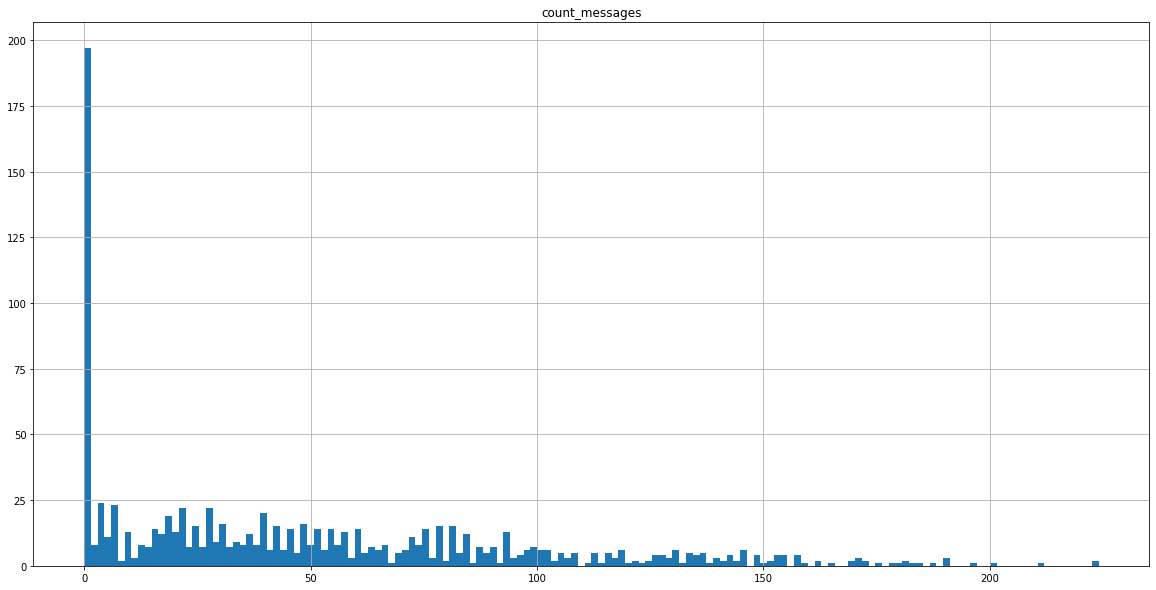

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: count_messages, dtype: float64


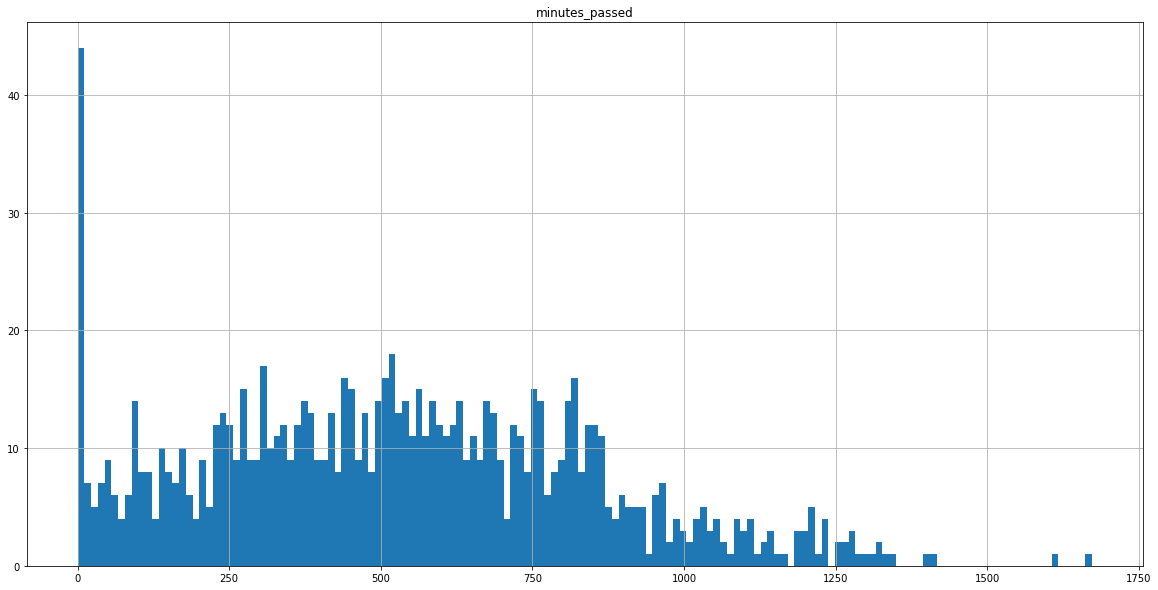

count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: minutes_passed, dtype: float64


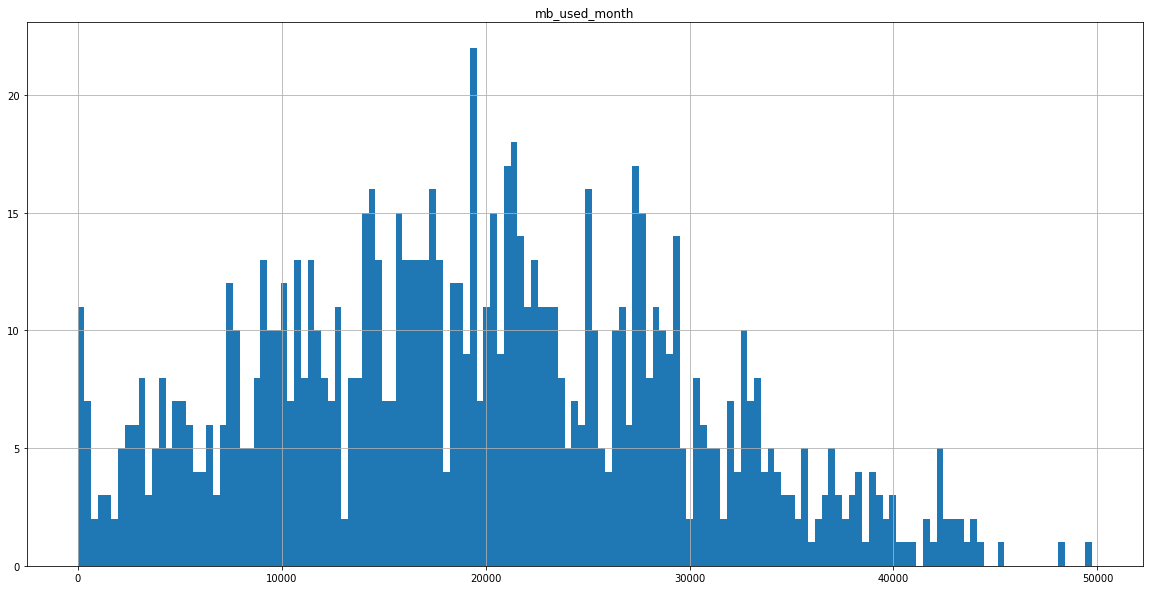

count      985.000000
mean     19468.805208
std      10087.170752
min          0.000000
25%      11770.260000
50%      19308.010000
75%      26837.690000
max      49745.690000
Name: mb_used_month, dtype: float64


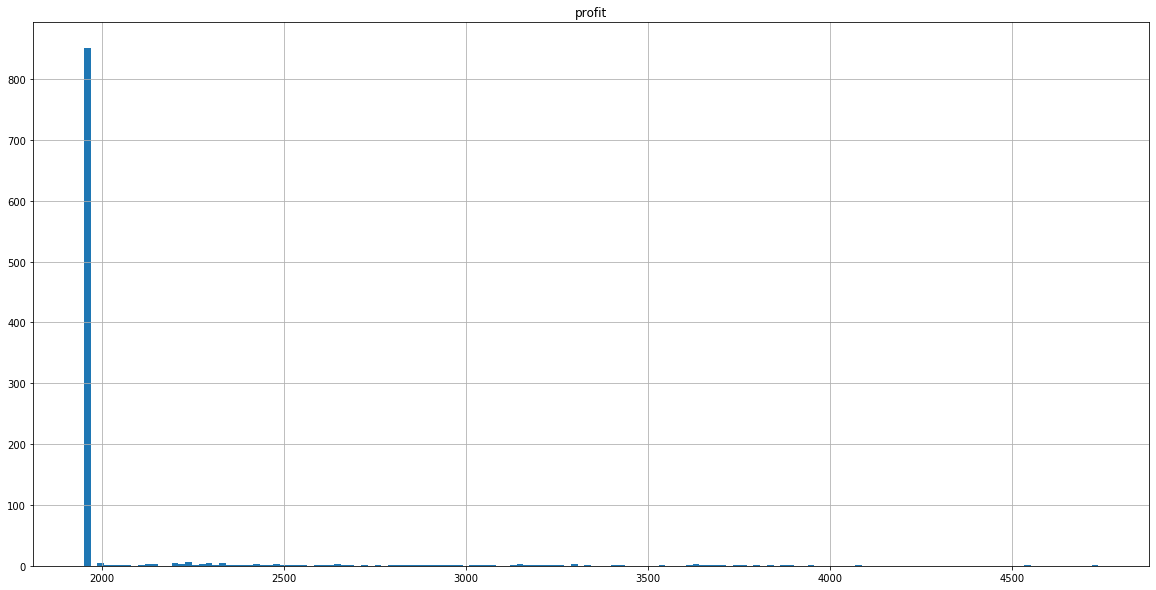

count     985.000000
mean     2059.879640
std       354.901048
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4737.011719
Name: profit, dtype: float64


In [72]:
for column in for_revenue.query('tariff == "ultra"')[['count_messages', 'minutes_passed', 'mb_used_month', 'profit']]:
    range_max = for_revenue.query('tariff == "ultra"')[column].max()
    range_min = for_revenue.query('tariff == "ultra"')[column].min()
    for_revenue.query('tariff == "ultra"')[column].hist(bins=150, range=(range_min, range_max), figsize=(20,10))
    plt.title(column)
    plt.show()
    print(for_revenue.query('tariff == "ultra"')[column].describe())

**ultra** : Большое количетсво людей, согласно гистограмме, отправляют до 3 сообщений. 25% людей, по данному тарифу отправляют до 6 сообщений, поэтому медиана меньше среднего (медиана равна 38, среднее 49), как и среднее отклонение зачительное, равное 48.  
Согласно гистограмме, большее скопление людей говорят до 10 минут, тогда как медиана значительная - 518 минут.  
Распределение потраченного трафика напоминает нормальное со средним 19449, медианой 19304 mb и значительным стандартным отклонением, равным 10096 mb.  
Выручка, в основном, равна 1950 с пользователя - плата за тариф, равная медиане. Максимальная выручка равна 4737 рубля.

Проанализируем тариф smart.

Найдем **дисперсию, среднюю, медиану, дисперсию, среднее отклонение минут разговора, сообщений и объема трафика** отдельно:

In [73]:
for column in interesting_values:
    print('Среднее {}: {:.0f}'.format(column,for_revenue.query('tariff == "smart"')[column].mean()))
    print('Медиана {}: {:.0f}'.format(column,for_revenue.query('tariff == "smart"')[column].median()))
    print('Дисперсия {}: {:.0f}'.format(column,np.var(for_revenue.query('tariff == "smart"')[column])))
    print('Стандартное отклонение {}: {:.0f} \n'.format(column, np.std(for_revenue.query('tariff == "smart"')[column])))

Среднее count_messages: 33
Медиана count_messages: 28
Дисперсия count_messages: 796
Стандартное отклонение count_messages: 28 

Среднее minutes_passed: 418
Медиана minutes_passed: 422
Дисперсия minutes_passed: 36203
Стандартное отклонение minutes_passed: 190 

Среднее mb_used_month: 16208
Медиана mb_used_month: 16507
Дисперсия mb_used_month: 34447035
Стандартное отклонение mb_used_month: 5869 

Среднее profit: 1230
Медиана profit: 958
Дисперсия profit: 617128
Стандартное отклонение profit: 786 



In [74]:
data_comparison_smart = {'smart':['','','',''],'Значение': ['count_messages','minutes_passed','mb_used_month','profit'],'Среднее': [33, 418, 16208, 1230], 
                         'Медиана': [28, 422, 16507, 958], 
                         'Дисперсия': [796,36203, 34447035, 617128], 'Стандартное отклонение':[28, 190, 5869, 786]}

In [75]:
data_comparison_smart = pd.DataFrame(data_comparison_smart)
data_comparison_smart

,smart,Значение,Среднее,Медиана,Дисперсия,Стандартное отклонение
0,,count_messages,33,28,796,28
1,,minutes_passed,418,422,36203,190
2,,mb_used_month,16208,16507,34447035,5869
3,,profit,1230,958,617128,786


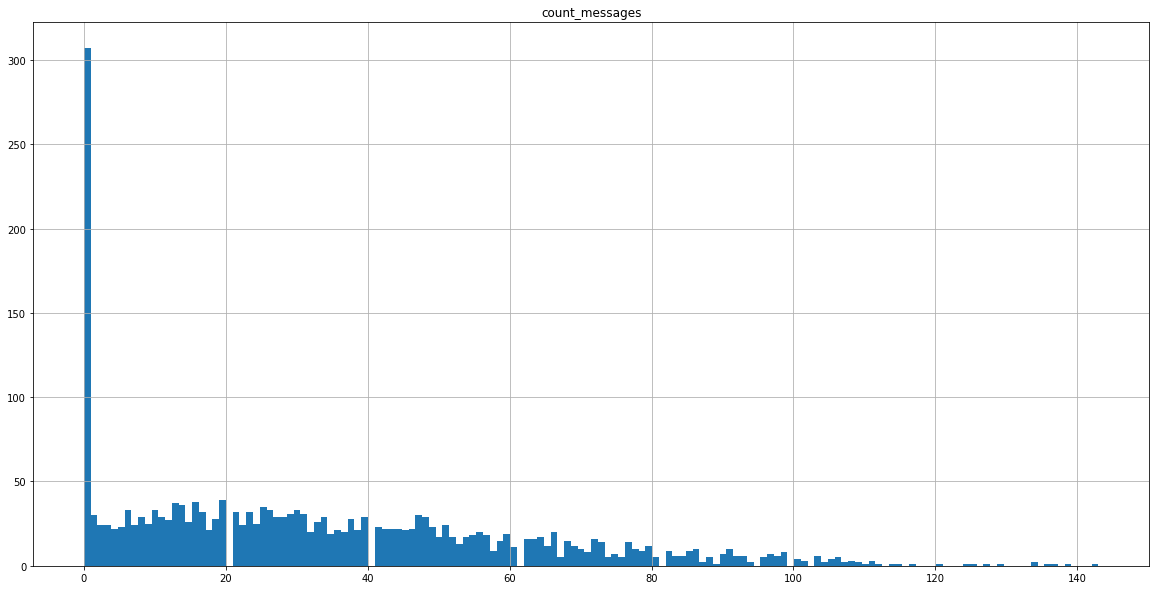

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: count_messages, dtype: float64


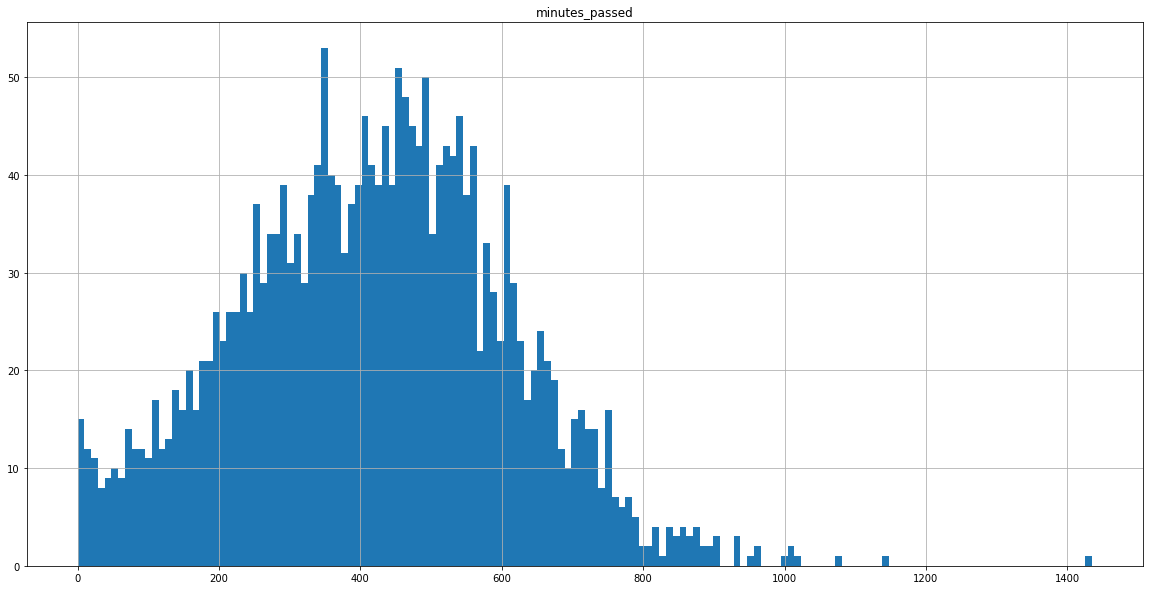

count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: minutes_passed, dtype: float64


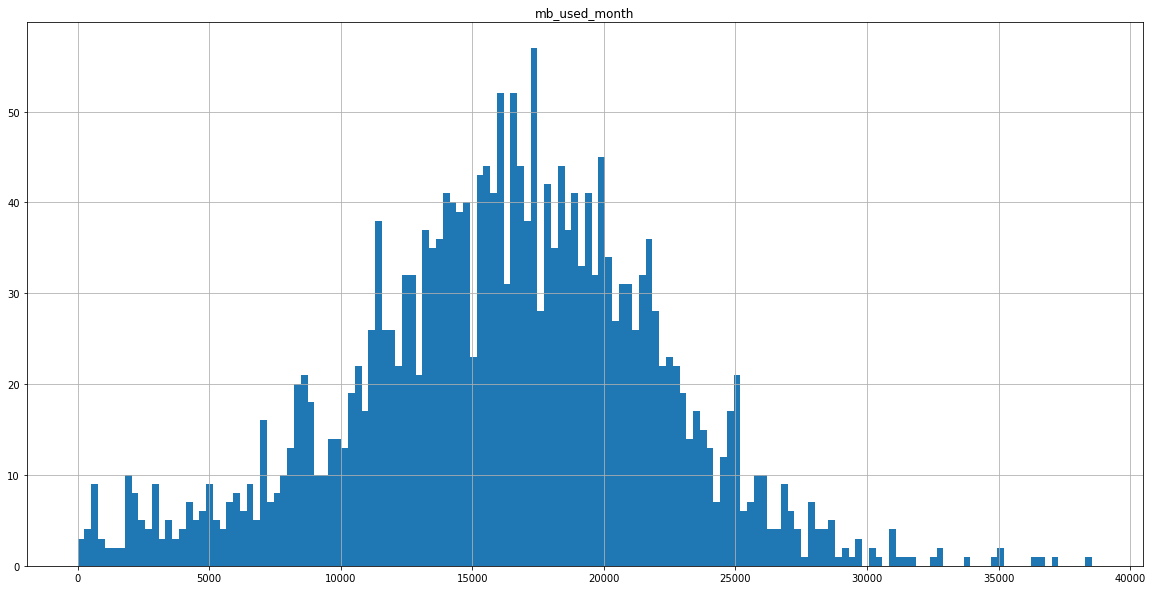

count     2229.000000
mean     16208.386990
std       5870.476681
min          0.000000
25%      12643.010000
50%      16506.840000
75%      20042.930000
max      38552.450000
Name: mb_used_month, dtype: float64


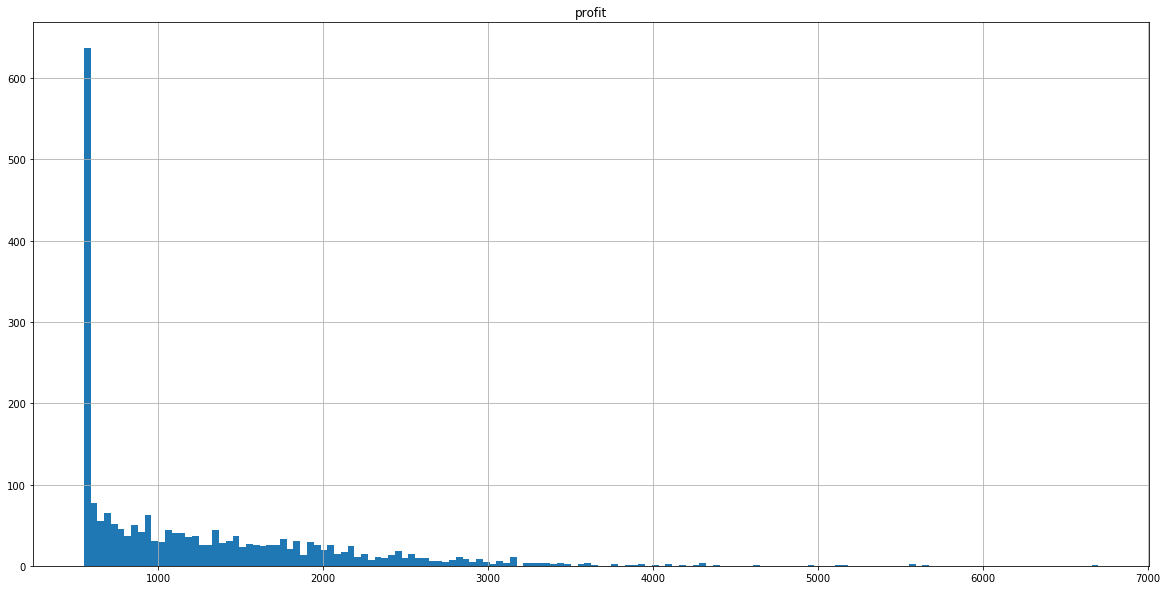

count    2229.000000
mean     1230.498290
std       785.751342
min       550.000000
25%       550.000000
50%       958.000000
75%      1665.625000
max      6699.882812
Name: profit, dtype: float64


In [76]:
for column in for_revenue.query('tariff == "smart"')[['count_messages', 'minutes_passed', 'mb_used_month', 'profit']]:
    range_max = for_revenue.query('tariff == "smart"')[column].max()
    range_min = for_revenue.query('tariff == "smart"')[column].min()
    for_revenue.query('tariff == "smart"')[column].hist(bins=150, range=(range_min, range_max), figsize=(20,10))
    plt.title(column)
    plt.show()
    print(for_revenue.query('tariff == "smart"')[column].describe())

**smart** : в основном, по данному тарифу согласно гистограмме, большое скопление людей отправляют отправляют до 1 сообщения, тогда как 25% людей в целом отправляют до 10 сообщений, поэтому медиана меньше среднего (медиана равна 28, среднее 33), как и стандартное отклонение зачительное, равное 28.  
Распределение потраченных минут напоминает нормальное со средним равным 418 минутам и стандартным отклонением 190 минут. Медиана равна 422 минутам.  
Распределение потраченного трафика также напоминает нормальное со средним 16201 mb, медианой 16505 mb и значительным стандартным отклонением, равным 5878 mb.  
Выручка до 25% выборки равна 550 с пользователя - плата за тариф, однако медиана равна 958 рублям. Максимальная выручка равна 6700 рубля с человека. 

Построим общие гистограммы на 1 графике:

In [77]:
def histogram(column, title):
    sns.set_style('darkgrid')
    plt.figure(figsize=(20,10))
    plt.title(title, fontsize=20)
    sns.distplot(for_revenue.query('tariff == "smart"')[column], label='Тариф Smart', kde=False)
    sns.distplot(for_revenue.query('tariff == "ultra"')[column], label='Тариф Ultra', kde=False)
    plt.axvline(np.mean(for_revenue.query('tariff == "smart"')[column]),color='b', linestyle='--', label='Smart среднее')
    plt.axvline(np.mean(for_revenue.query('tariff == "ultra"')[column]),color='r', linestyle='-', label='Ultra среднее')
    plt.legend()

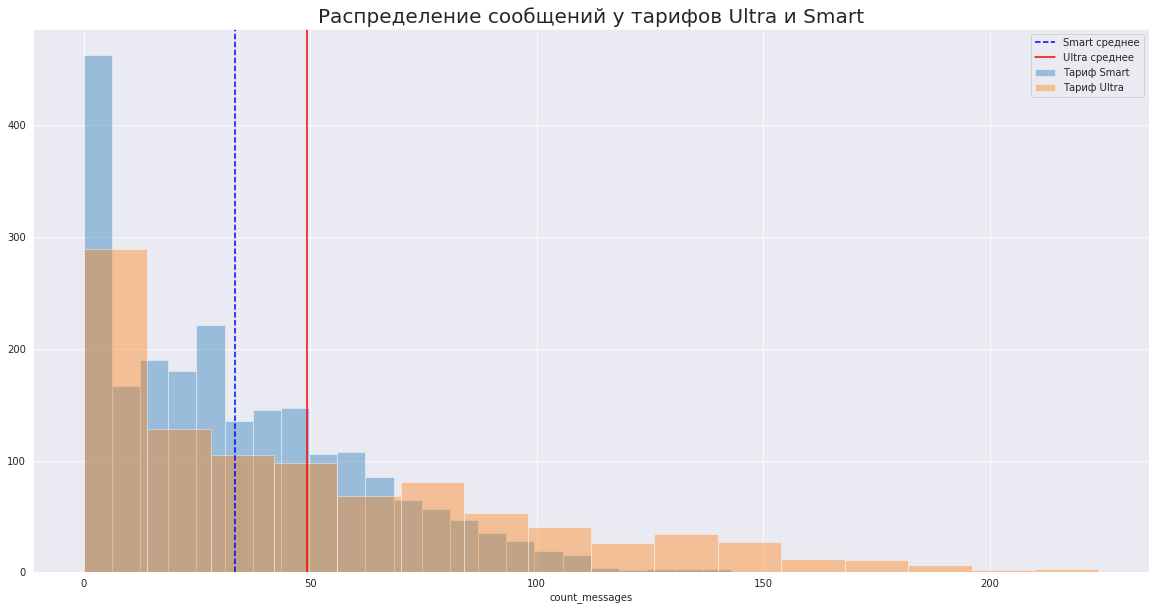

In [78]:
histogram('count_messages', 'Распределение сообщений у тарифов Ultra и Smart')

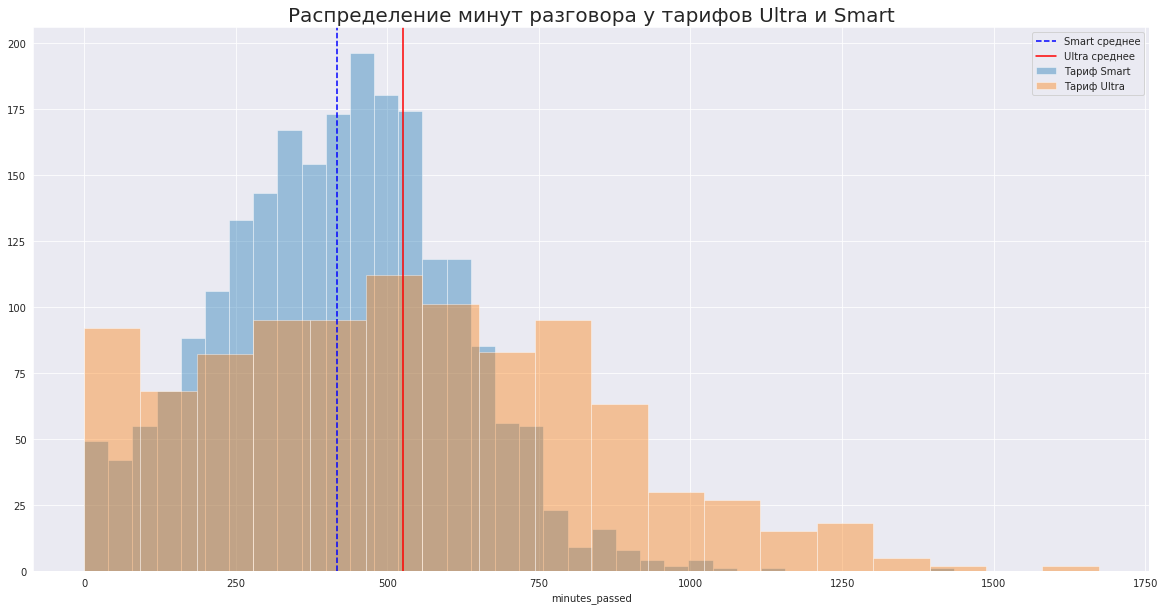

In [79]:
histogram('minutes_passed', 'Распределение минут разговора у тарифов Ultra и Smart')

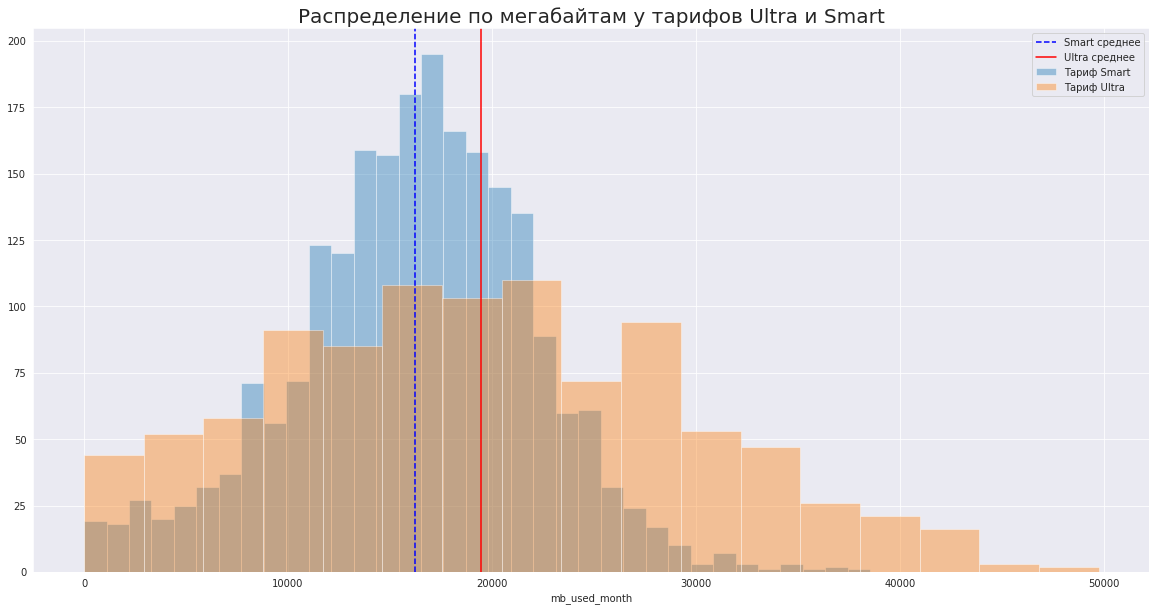

In [80]:
histogram('mb_used_month', 'Распределение по мегабайтам у тарифов Ultra и Smart')

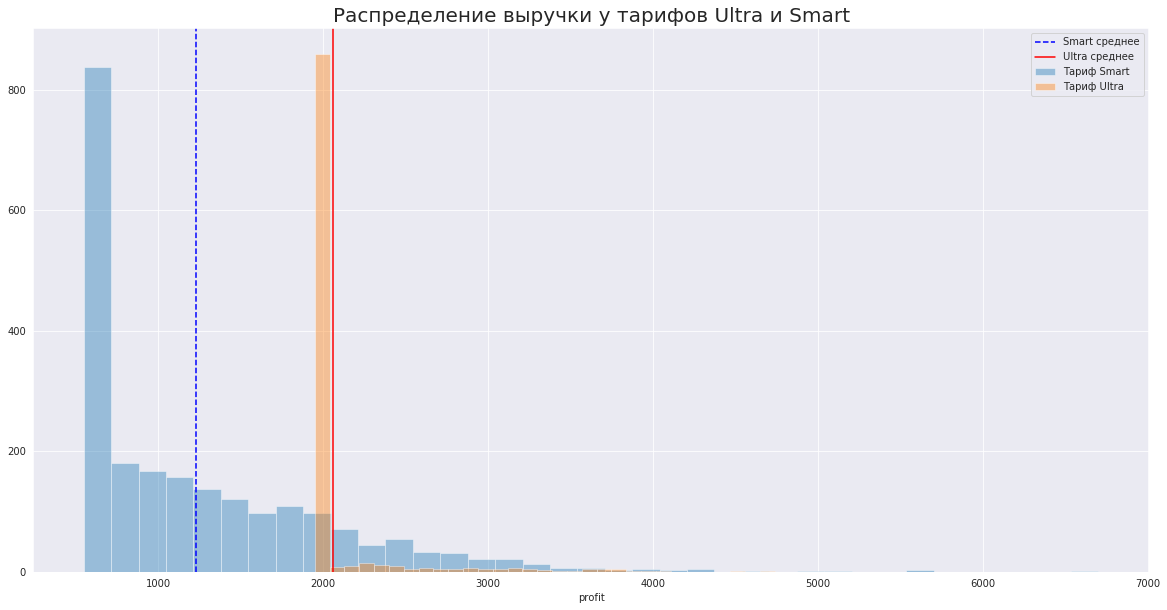

In [81]:
histogram('profit', 'Распределение выручки у тарифов Ultra и Smart')

Посмотрим суммарные показатели.

In [82]:
for_revenue

,user_id,tariff,month,count_messages,minutes_passed,mb_used_month,profit
0,1000,ultra,5.0,22.0,159.0,2253.49,1950.000000
1,1000,ultra,6.0,60.0,172.0,23233.77,1950.000000
2,1000,ultra,7.0,75.0,340.0,14003.64,1950.000000
3,1000,ultra,8.0,81.0,408.0,14055.93,1950.000000
4,1000,ultra,9.0,57.0,466.0,14568.91,1950.000000
...,...,...,...,...,...,...,...
3211,1498,smart,10.0,42.0,247.0,20579.36,1569.531250
3212,1499,smart,9.0,11.0,70.0,1845.75,550.000000
3213,1499,smart,10.0,48.0,449.0,17788.51,1024.414062
3214,1499,smart,11.0,59.0,612.0,17963.31,1421.593750


In [83]:
smart = users[users['tariff']=='smart']
ultra = users[users['tariff']=='ultra']

print('Количество клиентов с тарифом Ультра: {}'.format(ultra['tariff'].count()))
print('Количество клиентов с тарифом Смарт: {}\n'.format(smart['tariff'].count()))
print('В среднем один пользователь тарифа Ультра приносит: {:.0f} рублей'.format(for_revenue.query('tariff == "ultra"')['profit'].sum()/for_revenue.query('tariff == "ultra"')['profit'].count()))
print('В среднем один пользователь тарифа Смарт приносит: {:.0f} рублей\n'.format(for_revenue.query('tariff == "smart"')['profit'].sum()/for_revenue.query('tariff == "smart"')['profit'].count()))
print('Годавая прибыль по тарифу Ультра: {:.0f} рублей'.format(for_revenue.query('tariff == "ultra"')['profit'].sum()))
print('Годовая прибыль по тарифу Смарт: {:.0f} рублей\n'.format(for_revenue.query('tariff == "smart"')['profit'].sum()))

Количество клиентов с тарифом Ультра: 149
Количество клиентов с тарифом Смарт: 351

В среднем один пользователь тарифа Ультра приносит: 2060 рублей
В среднем один пользователь тарифа Смарт приносит: 1230 рублей

Годавая прибыль по тарифу Ультра: 2028981 рублей
Годовая прибыль по тарифу Смарт: 2742781 рублей



In [84]:
data_comparison_smart.merge(data_comparison_ultra, how='outer', on = 'Значение').fillna(1).rename(
columns={'Среднее_x':'Среднее_smart','Медиана_x':'Медиана_smart','Дисперсия_x':'Дисперсия_smart','Стандартное отклонение_x':'Стандартное отклонение_smart',
         'Среднее_y':'Среднее_ultra','Медиана_y':'Медиана_ultra','Дисперсия_y':'Дисперсия_ultra',
         'Стандартное отклонение_y':'Стандартное отклонение_ultra'}).drop(columns=['smart','ultra'])


,Значение,Среднее_smart,Медиана_smart,Дисперсия_smart,Стандартное отклонение_smart,Среднее_ultra,Медиана_ultra,Дисперсия_ultra,Стандартное отклонение_ultra
0,count_messages,33,28,796,28,49,38,2283,48
1,minutes_passed,418,422,36203,190,527,518,100771,317
2,mb_used_month,16208,16507,34447035,5869,19469,19308,101647713,10082
3,profit,1230,958,617128,786,2060,1950,125827,355


#### Вывод:

* **smart** гораздо популярнее **ultra** (более чем в 2 раза) из-за меньшей цены тарифа, что ожидаемо. Однако, за **smart** переплачивают гораздо чаще из-за меньшего числа включенных в тариф услуг, более того максимальная выручка от **smart** с человека выше на 41% тарифа **ultra**
* Годовая прибыль от тарифа **smart** выше за счет большой популярности тарифа из-за более дешевой месячной цены
* В целом, сообщений, в **ultra** отправляют больше, медианное количество минут у **ultra** также выше, как и потраченный трафик
* Насчет распределений гистограмм - распределение потраченного трафика **ultra** напоминает нормальное со средним 19449 mb и стандартным отклонением равным 10096 mb;
* Распределение потраченных минут **smart** напоминает нормальное со средним равным 418 минутам и стандартным отклонением 190 минут
* Распределение потраченного трафика **smart** напоминает нормальное со средним 16201 mb и стандартным отклонением равным 5878 mb

### Шаг 4. Проверка гипотез.

Проверим гипотезу о **равенстве средней выручки пользователей «Ультра» и «Смарт»**.
Дисперсии не равны, как было уже подсчитано ранее.  
**H0**: средняя выручка пользователей ultra равна средней выручки пользователей smart.  
**H1**: иначе

In [89]:
sample_1 = for_revenue.query('tariff == "smart"')['profit'] 
sample_2 = for_revenue.query('tariff == "ultra"')['profit'] 
results = st.ttest_ind(sample_1, sample_2, equal_var = False)
if results.pvalue<.01:
    print('Средняя выручки пользователей «Ультра» и «Смарт» не равна при 1% уровне значимости, нулевая гипотеза отвергается.')
else:
    print('Средняя выручки пользователей «Ультра» и «Смарт» равна при 1% уровне значимости, нулевая гипотеза не отвергается.')

Средняя выручки пользователей «Ультра» и «Смарт» не равна при 1% уровне значимости, нулевая гипотеза отвергается.


Проверим гипотезу о **равенстве средней выручки пользователей из Москвы и из других регионов**.  
**H0**: средняя выручка пользователей из Москвы равна средней выручки пользователей из других регионов.  
**H1**: иначе

Для проверки гипотезы создам новую таблицу состоящую из всех значений таблицы for_revenue и столбца с городами с таблицы users.

In [86]:
for_hypothesis = for_revenue.merge(users, on='user_id', how='outer').drop(columns=['age','churn_date',
                                'reg_date','tariff_y','name']).rename(columns={"tariff_x":"tariff"})
for_hypothesis

,user_id,tariff,month,count_messages,minutes_passed,mb_used_month,profit,city
0,1000,ultra,5.0,22.0,159.0,2253.49,1950.000000,Краснодар
1,1000,ultra,6.0,60.0,172.0,23233.77,1950.000000,Краснодар
2,1000,ultra,7.0,75.0,340.0,14003.64,1950.000000,Краснодар
3,1000,ultra,8.0,81.0,408.0,14055.93,1950.000000,Краснодар
4,1000,ultra,9.0,57.0,466.0,14568.91,1950.000000,Краснодар
...,...,...,...,...,...,...,...,...
3211,1499,smart,10.0,48.0,449.0,17788.51,1024.414062,Пермь
3212,1499,smart,11.0,59.0,612.0,17963.31,1421.593750,Пермь
3213,1499,smart,12.0,66.0,492.0,13055.58,598.000000,Пермь
3214,1128,NaN,NaN,NaN,NaN,NaN,NaN,Волжский


In [87]:
print(np.var(for_hypothesis.query('city == "Москва"')['profit']), 'Дисперсия дохода от москвичей')
print(np.var(for_hypothesis.query('city != "Москва"')['profit']), 'Дисперсия дохода не от москвичей')

545082.050701551 Дисперсия дохода от москвичей
628527.3500244766 Дисперсия дохода не от москвичей


In [88]:
sample_1 = for_hypothesis.query('city == "Москва"')['profit'] 
sample_2 = for_hypothesis.query('city != "Москва"')['profit'] 
results = st.ttest_ind(sample_1, sample_2, equal_var = False)
if results.pvalue<.01:
    print('Средняя выручки пользователей из Москвы и не из Москвы не равна при 1% уровне значимости, нулевая гипотеза отвергается.')
else:
    print('Средняя выручки пользователей из Москвы и не из Москвы равна при 1% уровне значимости, нулевая гипотеза не отвергается.')

Средняя выручки пользователей из Москвы и не из Москвы равна при 1% уровне значимости, нулевая гипотеза не отвергается.


#### Вывод:
* Средняя выручки пользователей «Ультра» и «Смарт» не равна при 1% уровне значимости, нулевая гипотеза отвергается.  
* Средняя выручки пользователей из Москвы и не из Москвы равна при 1% уровне значимости, нулевая гипотеза не отвергается.

### Общий вывод:

* Таблицы изучила, проверила их на наличие пустых значений, дубликатов, неправильных типов данных и предобротала их для анализа


* Посчитала сколько минут разговора, сколько сообщений и какой объем интернет-трафика требуется пользователям каждого тарифа в месяц, среднее количество, дисперсию и стандартное отклонение


* Проверила гипотезы: Выручка тарифов Смарт и Ультра различается, выручка клиентов с Москвы и других регионов не отличается - все на 1% уровне значимости. 
 
 
* Клиенты тарифа Ультра расходуют больше интернет-трафика, делают больше звонков и отправляют больше сообщений, чем клиенты тарифа Смарт и практически не превышают лимит своего пакета, чего не скажешь о клиентах тарифа Смарт. Однако, по годовой выручке, компания получает больше выручки по тарифу Смарт, так как пользователей данного тарифа больше чем Ультра - тариф просто популярнее из-за видимой экономии за пакет. Если считать по каждому пользователю то в среднем пользователь тарифа Ультра приносит больше выручки в год чем, пользователь Смарт. 


* Учитывая итоговую прибыль по пользователям от тарифов Ультра и Смарт, Смарт более выгоден для компании из-за большей популярности среди пользователей. По ценности каждого пользователя тарифа -  пользователь тарифа Ультра приносят больше дохода, чем один пользователь тарифа Смарт  